In [2]:
import keras
import keras.utils
from keras import utils as np_utils

In [3]:
import tensorflow.keras.layers
import tensorflow as tf



In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam
import cv2
import numpy as np


In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DR',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DR', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
    ) # set as validation data

input_img = Input(shape=(224, 224, 3))

Found 2248 images belonging to 5 classes.
Found 562 images belonging to 5 classes.


In [10]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
import tensorflow.keras.applications


# Load DenseNet-169 model without top layers
resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
resnet152 = keras.models.Sequential()

# Set layers in densenet169_model to non-trainable
for layer in resnet152_model.layers:
    layer.trainable = False

# Add layers to the model
resnet152.add(resnet152_model)
resnet152.add(Flatten())
resnet152.add(Dropout(0.2))
resnet152.add(Dense(1024, activation='relu'))
resnet152.add(Dropout(0.2))
resnet152.add(Dense(512, activation='relu'))
resnet152.add(Dense(5, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
resnet152.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy',precision_m, recall_m, f1_m])

# Assuming you have your ImageDataGenerators set up
# train_generator = ...
# validation_generator = ...

# Train the model
graph = resnet152.fit(train_generator, epochs=25, validation_data=validation_generator)
resnet152.save("/content/drive/My Drive/resnet152(ADAM_0.001).h5")


# Print the results
print(graph.history)


Epoch 1/25
71/71 [==============================] - 44s 395ms/step - loss: 4.6336 - accuracy: 0.4440 - precision_m: 0.5067 - recall_m: 0.3882 - f1_m: 0.4329 - val_loss: 1.1037 - val_accuracy: 0.6157 - val_precision_m: 0.9332 - val_recall_m: 0.2658 - val_f1_m: 0.4097
Epoch 2/25
71/71 [==============================] - 25s 351ms/step - loss: 1.2302 - accuracy: 0.5378 - precision_m: 0.7172 - recall_m: 0.3627 - f1_m: 0.4700 - val_loss: 1.0555 - val_accuracy: 0.5979 - val_precision_m: 0.9224 - val_recall_m: 0.3019 - val_f1_m: 0.4498
Epoch 3/25
71/71 [==============================] - 25s 346ms/step - loss: 1.2195 - accuracy: 0.5343 - precision_m: 0.7306 - recall_m: 0.3803 - f1_m: 0.4803 - val_loss: 1.1265 - val_accuracy: 0.5836 - val_precision_m: 0.8937 - val_recall_m: 0.2994 - val_f1_m: 0.4435
Epoch 4/25
71/71 [==============================] - 27s 379ms/step - loss: 1.1555 - accuracy: 0.5694 - precision_m: 0.7796 - recall_m: 0.3345 - f1_m: 0.4516 - val_loss: 1.0852 - val_accuracy: 0.6263 

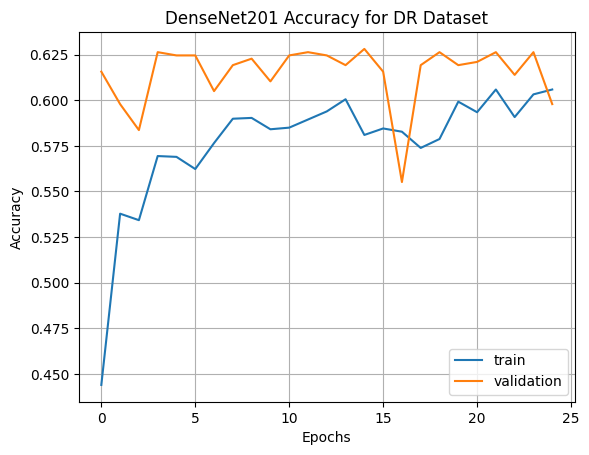

In [11]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['accuracy'])
plt.plot(graph.history['val_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet201 Accuracy for DR Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

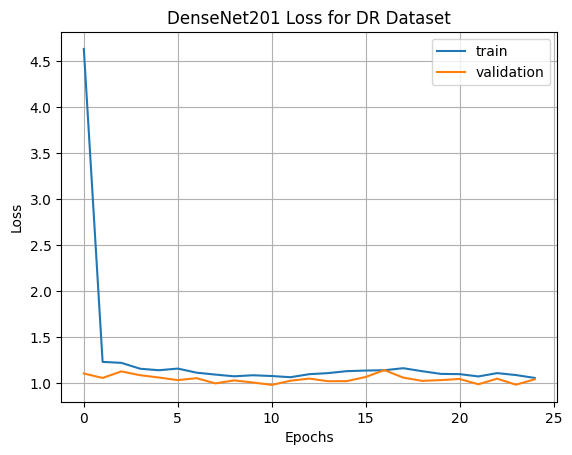

In [12]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet201 Loss for DR Dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()